<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Deep Learning Para Aplicações de Inteligência Artificial com Python e C++</font>
## <font color='blue'>Projeto 2</font>
## <font color='blue'>Fine-Tuning de Um Modelo Transformer Para Classificação de Sentimento</font>

Obs: Os pacotes abaixo estão aqui apenas para referência. Todos os pacotes, versões e dependências estão disponíveis no arquivo requirements.txt e o procedimento de instalação no arquivo LEIAME.txt

In [1]:
#!pip install -q -U watermark

In [2]:
#!pip install -q numpy==1.26.2

In [3]:
#!pip install -q spacy

In [4]:
#!pip install -q tensorflow

In [5]:
#!pip install -q keras

In [6]:
#!pip install -q keras-preprocessing

In [7]:
#!pip install -q transformers

In [8]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [9]:
# Imports
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, AUC
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [10]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando os Dados de Texto

In [11]:
# Carrega os dados de treino
dados_dsa_treino = pd.read_csv('dados_treino.txt', header = None, delimiter = ';')

In [12]:
# Carrega os dados de teste
dados_dsa_teste = pd.read_csv('dados_teste.txt', header = None, delimiter = ';')

In [13]:
# Ajusta os nomes das colunas
dados_dsa_treino = dados_dsa_treino.rename(columns = {0: 'texto', 1: 'sentimento'})
dados_dsa_teste = dados_dsa_teste.rename(columns = {0: 'texto', 1: 'sentimento'})

In [14]:
# Shape
dados_dsa_treino.shape

(16000, 2)

In [15]:
# Shape
dados_dsa_teste.shape

(2000, 2)

In [16]:
# Amostra de treino
dados_dsa_treino.head()

,texto,sentimento
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


> A coluna **texto** será a variável de entrada e **sentimento** a variável de saída.

In [17]:
# Sentimentos presentes nos dados de treino
dados_dsa_treino['sentimento'].value_counts()

sentimento
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [18]:
# Sentimentos presentes nos dados de teste
dados_dsa_teste['sentimento'].value_counts()

sentimento
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

## Pré-Processamento dos Dados de Texto com SpaCy

https://spacy.io/

In [19]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [20]:
# Carrega o dicionário
dsa_nlp = spacy.load('en_core_web_md')

In [21]:
# Definição da função 'dsa_preprocessa_texto' que recebe um texto como parâmetro
def dsa_preprocessa_texto(text):
    
    # Processa o texto usando o dicionário
    doc = dsa_nlp(text)

    # Cria uma lista de lemas dos tokens, convertidos para minúsculas e sem espaços em branco,
    # excluindo as palavras que são stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    # Retorna os tokens processados como uma string única, unindo-os com espaços
    return ' '.join(tokens)

In [22]:
# Aplica a função em treino
dados_dsa_treino['texto_processado'] = dados_dsa_treino['texto'].apply(dsa_preprocessa_texto)

In [23]:
# Aplica a função em teste
dados_dsa_teste['texto_processado'] = dados_dsa_teste['texto'].apply(dsa_preprocessa_texto)

In [24]:
# Amostra de dados
dados_dsa_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


## Versão 1 do Modelo - Arquitetura Fully Connected Neural Network

### Passo1: Vetorização com TF-IDF

In [25]:
# Cria o vetorizador
dsa_tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

Esta linha acima cria uma instância do TfidfVectorizer da biblioteca scikit-learn, que é uma ferramenta utilizada para converter uma coleção de documentos brutos em uma matriz de recursos TF-IDF (Term Frequency-Inverse Document Frequency). O TF-IDF é uma técnica estatística usada para quantificar a importância de uma palavra em um conjunto de documentos, comumente utilizada em tarefas de processamento de linguagem natural e recuperação de informações.

**Parâmetro max_df=0.95**: Este parâmetro define o limite máximo de frequência de documento para os termos que serão considerados. Aqui, está definido como 0.95, o que significa que palavras que aparecem em mais de 95% dos documentos serão ignoradas. Isso ajuda a eliminar palavras comuns que não contribuem muito para o significado do texto.

**Parâmetro min_df=2**: Este parâmetro estabelece a frequência mínima de documento para os termos. Neste caso, termos que aparecem em menos de 2 documentos serão ignorados. Isso ajuda a filtrar termos raros que podem ocorrer apenas em poucas amostras e, portanto, são menos relevantes para a análise geral.

**Parâmetro stop_words='english'**: Este parâmetro instrui o vetorizador a remover todas as palavras de parada em inglês da análise. Palavras de parada são palavras comuns (como "e", "o", "em") que geralmente são filtradas em processamento de linguagem natural porque são muito frequentes e não carregam informações significativas para a análise de texto.

In [26]:
# Aplica o vetorizador
dados_treino_tfidf = dsa_tfidf.fit_transform(dados_dsa_treino['texto_processado'])
dados_teste_tfidf = dsa_tfidf.transform(dados_dsa_teste['texto_processado'])

In [27]:
dados_treino_tfidf.shape

(16000, 5587)

In [28]:
type(dados_treino_tfidf)

scipy.sparse._csr.csr_matrix

In [29]:
# Converte os dados de entrada (texto) para array
X_treino_array = dados_treino_tfidf.toarray()
X_teste_array = dados_teste_tfidf.toarray()

### Passo 2: Preparação dos Dados

Precisamos agora converter a variável alvo para representação numérica. Usaremos Label Encoding.

In [30]:
# Cria o label encoder
dsa_le = LabelEncoder()

In [31]:
# Faz o fit e transform na variável alvo em treino
y_treino_le = dsa_le.fit_transform(dados_dsa_treino['sentimento'])

In [32]:
# Faz transform na variável alvo em teste
y_teste_le = dsa_le.transform(dados_dsa_teste['sentimento'])

Vamos tratar de forma automática o desbalanceamento de classe.

In [33]:
# Peso das classes
pesos_classes = compute_class_weight('balanced', classes = np.unique(y_treino_le), y = y_treino_le)

In [34]:
type(pesos_classes)

numpy.ndarray

**compute_class_weight**: Esta é uma função do scikit-learn que calcula os pesos para as classes. Esses pesos podem ser usados em modelos de classificação para dar mais importância a classes que são sub-representadas no conjunto de dados.

**'balanced'**: Este parâmetro indica que os pesos das classes devem ser calculados de forma que equilibrem o conjunto de dados. Isso é feito inversamente proporcional à frequência das classes no conjunto de dados. Classes mais frequentes recebem um peso menor, enquanto classes menos frequentes recebem um peso maior.

**classes = np.unique(y_treino_le)**: Aqui, np.unique(y_treino_le) encontra todas as classes únicas no conjunto de dados de treinamento. O parâmetro classes informa à função compute_class_weight quais são essas classes únicas.

**y = y_treino_le**: Este é o vetor de rótulos do conjunto de dados de treinamento. A função usará esses rótulos para calcular a frequência de cada classe.

O resultado, armazenado em pesos_classes, é um array onde cada classe tem um peso associado. Esses pesos podem ser usados em modelos de classificação (como uma árvore de decisão, um modelo de regressão logística, SVM, etc.) para compensar o desequilíbrio entre as classes.

In [35]:
# Divisão em Dados de Treino e Teste (validação)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino_array, 
                                                    y_treino_le, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y_treino_le)

In [36]:
# Ajusta a variável alvo como tipo categórico
y_treino_encoded = to_categorical(y_treino)
y_teste_encoded = to_categorical(y_teste_le)
y_val_encoded = to_categorical(y_val)

In [37]:
# Shape
y_treino_encoded.shape, y_teste_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

### Passo 3:  Construção do Modelo

In [38]:
# Cria o modelo

# Inicializa um modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.
modelo_dsa_v1 = Sequential() 

# Adiciona a primeira camada densa (fully-connected) ao modelo
modelo_dsa_v1.add(Dense(4096, 
                        
                        # Utiliza a função de ativação SELU (Scaled Exponential Linear Unit)
                        activation = 'selu',  
                        
                        # Inicializa os pesos com a distribuição LeCun normal
                        kernel_initializer = 'lecun_normal',  
                        
                        # Define o formato da entrada com base no número de features do X_treino
                        input_shape = (X_treino.shape[1],),  
                        
                        # Aplica regularização L2 para reduzir o overfitting
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adiciona a segunda camada densa
modelo_dsa_v1.add(Dense(2048, 
                        activation = 'selu',  
                        kernel_initializer = 'lecun_normal',  
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adiciona a terceira camada densa
modelo_dsa_v1.add(Dense(1024, 
                        activation = 'selu',  
                        kernel_initializer = 'lecun_normal',  
                        kernel_regularizer = tf.keras.regularizers.l2(0.1)))  

# Adiciona a quarta camada densa
# Camada com 64 neurônios e ativação SELU
modelo_dsa_v1.add(Dense(64, activation = 'selu',))  

# Adiciona a camada de saída
# Camada de saída com 6 neurônios e ativação softmax para classificação multiclasse
modelo_dsa_v1.add(Dense(6, activation = 'softmax'))  

### Passo 4:  Compilação e Sumário do Modelo

In [39]:
# Atribui pesos específicos ao vetor de bias da última camada do modelo
modelo_dsa_v1.layers[-1].bias.assign(pesos_classes)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [40]:
# Compila o modelo
# Define o otimizador como 'Adam'. 
# Adam é um algoritmo de otimização que pode ser usado no lugar do procedimento clássico de descida 
# do gradiente estocástica para atualizar os pesos da rede iterativamente com base nos dados de treinamento.
# Define a função de perda como 'categorical_crossentropy'. É adequada para problemas de classificação 
# multiclasse, onde os rótulos são fornecidos em um formato one-hot encoded.
# Define a métrica de avaliação do modelo como 'accuracy' (acurácia). 
# A acurácia é uma métrica comum para avaliar o desempenho de modelos de classificação.
modelo_dsa_v1.compile(optimizer = 'Adam',  
                      loss = tf.losses.categorical_crossentropy,  
                      metrics = ['accuracy'])  

In [41]:
modelo_dsa_v1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │    22,888,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,443,270 (127.58 MB)

 Trainable params: 33,443,270 (127.58 MB)

 Non-trainable params: 0 (0.00 B)

### Passo 5:  Callbacks e Early Stopping

In [42]:
# Função para os parâmetros de scheduler da taxa de aprendizado
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [43]:
# Scheduler da taxa de aprendizado
lr_scheduler = LearningRateScheduler(step_decay)

In [44]:
# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 3) 

### Passo 6:  Treinamento do Modelo

In [45]:
# Hiperparâmetros
num_epochs = 20
tamanho_batch = 256

Treinamento do modelo.

In [46]:
%%time
history = modelo_dsa_v1.fit(X_treino, 
                            y_treino_encoded, 
                            validation_data = (X_val, y_val_encoded), 
                            epochs = num_epochs, 
                            batch_size = tamanho_batch, 
                            callbacks = [early_stopping, lr_scheduler])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.4880 - loss: 77.6248 - val_accuracy: 0.7406 - val_loss: 2.2952 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7883 - loss: 1.7160 - val_accuracy: 0.7959 - val_loss: 1.3593 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8268 - loss: 1.2059 - val_accuracy: 0.8128 - val_loss: 1.2109 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8611 - loss: 1.0654 - val_accuracy: 0.8066 - val_loss: 1.2349 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8878 - loss: 0.9962 - val_accuracy: 0.8250 - val_loss: 1.1667 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9078 - loss: 0.9300 - val_accuracy: 0.8259 - val_loss: 1.1215 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9140 - loss: 0.8787 - val_ac

### Passo 7:  Avaliação do Modelo

In [47]:
# Extrai o erro em treino e validação
loss, val_loss = history.history['loss'], history.history['val_loss']

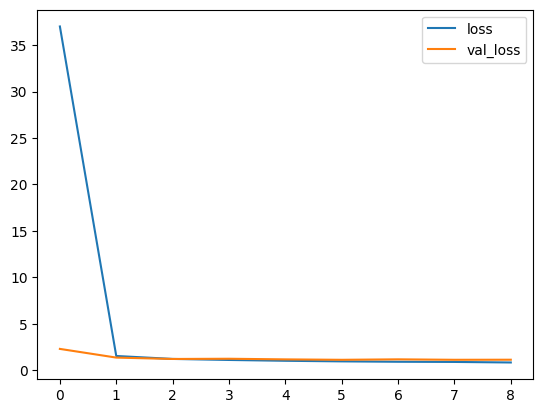

In [48]:
# Plot
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [49]:
# Previsões com dados de teste
previsoes_v1 = modelo_dsa_v1.predict(X_teste_array)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [50]:
# Extrai os labels
previsoes_v1_labels = previsoes_v1.argmax(axis = 1)

In [51]:
print(classification_report(y_teste_le, previsoes_v1_labels))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       275
           1       0.80      0.78      0.79       224
           2       0.81      0.93      0.87       695
           3       0.63      0.67      0.65       159
           4       0.93      0.80      0.86       581
           5       0.71      0.48      0.58        66

    accuracy                           0.83      2000
   macro avg       0.79      0.75      0.76      2000
weighted avg       0.83      0.83      0.83      2000



In [52]:
print(confusion_matrix(y_teste_le, previsoes_v1_labels))

[[229  11  12   7  16   0]
 [ 10 175   8  10   9  12]
 [  5   3 644  33   9   1]
 [  5   2  45 107   0   0]
 [ 22  17  72   3 467   0]
 [  2  11  11  10   0  32]]


In [53]:
print(accuracy_score(y_teste_le, previsoes_v1_labels))

0.827


In [54]:
# Salva o modelo
modelo_dsa_v1.save('modelo_dsa_v1.keras')  

### Passo 8:  Deploy da Versão 1 do Modelo

In [55]:
# Carrega o modelo
modelo_carregado = load_model('modelo_dsa_v1.keras')  

In [56]:
# Nova frase (sentimento = medo (fear))
frase = "i even feel a little shaky"

In [57]:
# Cria um dataframe com a frase
df_novo = pd.DataFrame({'Frase': [frase]})

In [58]:
# Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(dsa_preprocessa_texto)

In [59]:
df_novo

,Frase,Frase_Processada
0,i even feel a little shaky,feel little shaky


In [60]:
# Aplica a vetorização
df_novo_tfidf = dsa_tfidf.transform(df_novo['Frase_Processada'])

In [61]:
# Transforma em array
df_novo_array = df_novo_tfidf.toarray()

In [62]:
# Previsões
previsoes = modelo_carregado.predict(df_novo_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [63]:
previsoes

array([[1.2174511e-03, 9.8738283e-01, 5.4292665e-05, 1.4186983e-03,
        4.7755861e-03, 5.1512206e-03]], dtype=float32)

In [64]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [65]:
classe_maior_prob

array([1])

In [66]:
# Obtém o nome da classe
nome_classe = dsa_le.inverse_transform(classe_maior_prob)

In [67]:
# Classe prevista
nome_classe

array(['fear'], dtype=object)

# Continuaremos no próximo capítulo.

In [68]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [69]:
#%watermark -v -m

In [70]:
#%watermark --iversions

# Fim